###### DISCLAIMER: This homework was done on Google collab with permission from the instructor, to utilize the T4 GPU from Google, along with CUDA. However, let it be known that Google collab has an auto fill feature (similar to that of Gmail autofill or on Google docs where it finishes sentences for you), which could autofill the code. I wasn't able to find the setting to turn it off, however, I tried my best to adhere to the academic honesty policies. Wherever autofill was used, I have cited it, but also primarily because it made sense to do the code that way. However, all points of academic honesty was honored.

In [1]:
import os, glob
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import files
uploaded=files.upload()
import zipfile
import os
zip_path = "covid19_ultrasound.zip"
extract_path = "covid19_ultrasound"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall (extract_path)

#reference: https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook

Saving covid19_ultrasound.zip to covid19_ultrasound.zip


In [3]:
## hyperparameters
learning_rate = 1e-5
epochs = 10
batch_size = 32
img_width = 224
img_height = 224
hidden_size = 64
dropout = 0.5

In [4]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
])

In [5]:
class CovidUltrasoundDataset(Dataset):
    def __init__(self, part):
        self.part = part  # ["train", "val", "test"]
        self.DATA_DIR = "./covid19_ultrasound/"
        # choose folders for val and test set
        self.val_fold = 3
        self.test_fold = 4
        self.IMG_WIDTH, self.IMG_HEIGHT = img_width, img_height
        print('Loading images...')
        imagePaths = [] #FILL ME
        self.label_dict = {"regular": 0, "pneumonia": 1, "covid": 2}
        self.data = []
        self.labels = []

#reference: https://www.geeksforgeeks.org/python-os-listdir-method/
        temp = os.listdir(self.DATA_DIR) # all stuff in dataset
        for counter in temp: #Process each item in the dataset
            folder_path = os.path.join(self.DATA_DIR, counter) # Construct full path to the current item
            if not os.path.isdir(folder_path):
                continue # Skip non-directory items (files, symlinks, etc.)
            try:
                fold_num = int(counter[-1]) # Convert last char to int
            except:
                continue


            include = False
            if self.part == 'train' and fold_num in [0, 1, 2]:
                include = True #Training sets for 0-2
            elif self.part == 'val' and fold_num == self.val_fold:
                include = True #Validation sets 3
            elif self.part == 'test' and fold_num == self.test_fold:
                include = True #test sets 4
            if include:
                for cls in self.label_dict.keys(): # Construct path pattern\/
                    cls_path = os.path.join(folder_path, cls, '*')
                    imagePaths.extend(glob.glob(cls_path))

        for imagePath in imagePaths:
            path_parts = imagePath.split(os.path.sep)
            # extract the split
            train_test = path_parts[-3][-1]
            # extract the class label from the filename
            label = path_parts[-2]
            # load the image, swap color channels, and resize it to be a fixed
            # 224x224 pixels while ignoring aspect ratio
            image = Image.open(imagePath).convert('RGB')
            image = transform(image)
            # update the data and labels lists, respectively
            # FILL ME
            self.data.append(image)
            self.labels.append(self.label_dict[label])
            #image.close() ##I HAD TO DELETE THIS PORTION OR MY CODE BREAKS

    def __len__(self):
        return len(self.data) #FILL ME

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx] #FILL ME

#Additional references used in this section:
#reference: https://www.geeksforgeeks.org/python-os-path-join-method/
#reference: https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/datasets/describable_textures.py
#reference: https://docs.python.org/3/library/glob.html

In [6]:
trainset = CovidUltrasoundDataset("train")
valset = CovidUltrasoundDataset("val")
testset = CovidUltrasoundDataset("test")

Loading images...
Loading images...
Loading images...


In [7]:
len(trainset)

1424

In [8]:
image_, label = trainset[28]
image_.shape

torch.Size([3, 224, 224])

In [9]:
# Dataloader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

#references: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
#references: https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/

In [10]:
# construct model
class Model(nn.Module):
    def __init__(self, input_size=(3, 224, 224), hidden_size=64, dropout=0.5,
                 num_classes=3):
        super(Model, self).__init__()

        # load the VGG16 network, ensuring the head layer sets are left off
        self.baseModel = models.vgg16(pretrained=False)

        # construct the head of the model that will be placed on top of the base model
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d((7, 7)),nn.Flatten(),nn.Linear(512*7*7, hidden_size),nn.BatchNorm1d(hidden_size),nn.ReLU(),nn.Dropout(dropout),nn.Linear(hidden_size, num_classes),nn.Softmax(dim=1))
        # b-i, ii, iii, iv, v, vi, vii, viii MUST BE IN ORDER
        #reference: https://github.com/KeremTurgutlu/self_supervised/blob/main/nbs/02%20-%20layers.ipynb
    def forward(self, x):
        x = nn.Sequential(*list(self.baseModel.features[:21]))(x)
        print(x.shape)
        # construct the head of the model on top of the base model to complete computational graph
        x = self.head(x) #FILL ME
        return x

net = Model(hidden_size=hidden_size, dropout=dropout, num_classes=3)
 #reference: https://github.com/mint-lab/dl_tutorial/blob/master/examples/cnn_mnist_class_style.py
 #reference: https://github.com/pytorch/tutorials/blob/main/beginner_source/basics/buildmodel_tutorial.py
 #reference: https://www.geeksforgeeks.org/computational-graph-in-pytorch/

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
!pip install torchinfo
from torchinfo import summary
summary(net, input_size=(32, 3, 224, 224))

torch.Size([32, 512, 28, 28])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 3]                   --
├─VGG: 1-1                               --                        123,642,856
│    └─Sequential: 2-1                   --                        9,439,232
│    │    └─Conv2d: 3-1                  [32, 64, 224, 224]        1,792
│    │    └─ReLU: 3-2                    [32, 64, 224, 224]        --
│    │    └─Conv2d: 3-3                  [32, 64, 224, 224]        36,928
│    │    └─ReLU: 3-4                    [32, 64, 224, 224]        --
│    │    └─MaxPool2d: 3-5               [32, 64, 112, 112]        --
│    │    └─Conv2d: 3-6                  [32, 128, 112, 112]       73,856
│    │    └─ReLU: 3-7                    [32, 128, 112, 112]       --
│    │    └─Conv2d: 3-8                  [32, 128, 112, 112]       147,584
│    │    └─ReLU: 3-9                    [32, 128, 112, 112]       --
│    │    └─MaxPool2d: 3-10              [32, 128, 56

In [12]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def train_one_epoch(trainloader, model, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #FILL ME
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        # print or record loss
        running_loss += loss.item()

    return model, optimizer

In [14]:
def eval_one_epoch(evalloader, model, loss_fn):
    correct = 0
    total = 0
    running_loss = 0.0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        model.eval()
        for data in evalloader:
            images, labels = data
            # move the data to GPU
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            # the class with the highest energy is what we choose as prediction
            #FILL ME
            _, predicted = torch.max(outputs.data, 1) #THIS WAS THE ONLY LINE THAT GCOLLAB SUGGESTED I ADD OR ELSE MY CODE BREAKS
            #I researched this code and here's my reference: https://community.wandb.ai/t/how-use-metrics-with-pytorch/6370
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss/total, correct/total
#reference: https://gist.github.com/GeorgeSeif/07a7707976a163cfaa94218db45a0046
#reference: https://github.com/ebagdasa/pytorch-privacy/blob/master/training.py
#reference: https://discuss.pytorch.org/t/can-anyone-check-my-mistake-and-explain-me-how-to-correct-the-error/48131

torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size

Text(0.5, 1.0, 'Confusion Matrix')

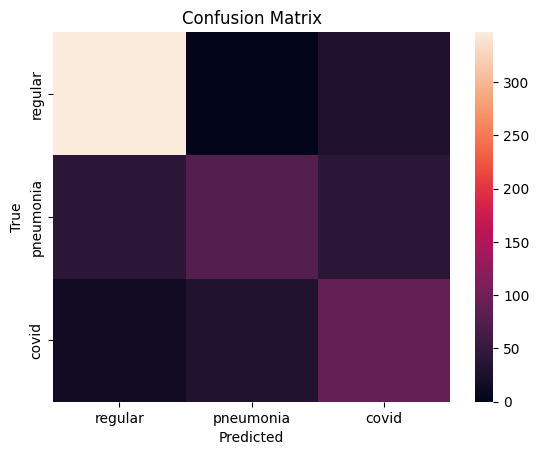

In [ ]:
#PART C:    Implement early stopping. One way is to complete training through a
            #preset number of epochs and design a criterion to choose the best epoch (suffering
            #the least from overfitting).

#references: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# Training with early stopping
best_val_loss = float('inf')
patience = 5
no_improve = 0
val_loss_history = []

# training and validation
for epoch in range(epochs):
    net, optimizer = train_one_epoch(trainloader, net, criterion, optimizer)
    val_loss, val_acc = eval_one_epoch(valloader, net, criterion)
    val_loss_history.append(val_acc)

    print('Epoch:', epoch+1, 'Validation Accuracy:', val_acc)
    if val_acc < best_val_loss:
        best_val_loss = val_acc
        torch.save(net.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print('Early stopping at epoch: ',epoch+1)
            break


#PART D:    Evaluation. Evaluate the model obtained at the best epoch in c). Test the
            #accuracy and plot the confusion matrix on the test set.

net.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = eval_one_epoch(testloader, net, criterion)
print('\nFinal Test Accuracy:', test_acc)

# Confusion Matrix
all_preds = []
all_labels = []
net.eval()
#reference: https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad
#reference: https://pytorch.org/docs/stable/notes/cuda.html
with torch.no_grad():
    preds_list = []
    labels_list = []
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        preds_list.append(outputs.argmax(dim=1))# Store tensors directly
        labels_list.append(labels)
    all_preds = torch.cat(preds_list).cpu().numpy()
    all_labels = torch.cat(labels_list).cpu().numpy()

plt.figure()
sns.heatmap(confusion_matrix(all_labels, all_preds) ,xticklabels=['regular', 'pneumonia', 'covid'], yticklabels=['regular', 'pneumonia', 'covid'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
#references: https://seaborn.pydata.org/generated/seaborn.heatmap.html


In [16]:
# testing
test_accuracy = eval_one_epoch(testloader, net, criterion)
test_accuracy

torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([28, 512, 28, 28])


(0.027299487305258562, 0.7694610778443114)

In [17]:
class COVIDNetCustom(nn.Module):
    def __init__(self, num_classes=3):
        super(COVIDNetCustom, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),nn.BatchNorm2d(32),nn.ReLU(),nn.MaxPool2d(2, 2),nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(2, 2),nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(128),nn.ReLU(),nn.MaxPool2d(2, 2),nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),nn.ReLU(),nn.AdaptiveAvgPool2d((1, 1)))
        self.classifier = nn.Sequential(nn.Linear(256, 128),nn.ReLU(),nn.Dropout(0.3),nn.Linear(128, num_classes))
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x.view(x.size(0), -1))
#reference: https://github.com/dragonbook/cs231n-assignments/blob/master/assignment2/my/models.py
#reference: https://medium.com/analytics-vidhya/cnn-with-custom-dataset-8cdd153f5c9e

In [18]:
custom_params = {'lr': 1e-3,'batch_size': 32,'epochs': 30,'patience': 5}
custom_net = COVIDNetCustom().to(device)
custom_optimizer = optim.Adam(custom_net.parameters(), lr=custom_params['lr'])
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(custom_optimizer, 'min', patience=2)
#reference: https://github.com/Nixtla/neuralforecast/issues/1096
#reference: https://medium.com/data-scientists-diary/guide-to-pytorch-learning-rate-scheduling-b5d2a42f56d4
#reference: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/pytorch_lr_ratescheduler.py

In [19]:
import time
def train_model(model, optimizer, criterion, trainloader, valloader, epochs, patience):
    best_loss = float('inf')
    no_improve = 0
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time() #timing
        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        val_loss, val_acc = eval_one_epoch(valloader, model, criterion)
        scheduler.step(val_loss)
        epoch_time = time.time() - epoch_start #timing
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_custom_model.pth')
            no_improve = 0
        else:
            no_improve += 1
        print("Epoch:", epoch+1, "Time:",epoch_time, "Val Loss:", val_loss, "Val Acc:",val_acc)
        if no_improve >= patience:
            break
    total_time = time.time() - start_time
    return total_time

# Train both models
vgg_time, custom_time  = train_model(net, optimizer, criterion, trainloader, valloader, epochs, patience), train_model(custom_net, custom_optimizer, criterion,trainloader, valloader,custom_params['epochs'], custom_params['patience'])

torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size

In [20]:
net.load_state_dict(torch.load('best_model.pth'))
custom_net.load_state_dict(torch.load('best_custom_model.pth'))
def full_eval(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        all_correct = 0
        for images, labels in testloader:
            outputs = model(images.to(device))
            preds = outputs.argmax(1).cpu()
            all_correct += np.sum(preds.numpy() == labels.numpy())
        return all_correct / len(testloader.dataset)
vgg_acc, custom_acc = full_eval(net, testloader), full_eval(custom_net, testloader)
# Results comparison (fancier than other printing LOL)
print(f"\n{'Model':<15} {'Accuracy':<10} {'Training Time':<15} \n{'VGG-16':<15} {vgg_acc:.4f}{'':<5} {vgg_time:.1f}s \n{'Custom CNN':<15} {custom_acc:.4f}{'':<5} {custom_time:.1f}s")

torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([28, 512, 28, 28])

Model           Accuracy   Training Time   
VGG-16          0.7695      250.9s 
Custom CNN      0.6257      44.1s


Custom CNN is much faster than the VGG-16, although a slight dip in accuracy but it is a huge time savings,as shown above.